# Eigenworm demo
We'll write a simple version of the eigenworm method of describing worm posture.

## Import some libraries

In [76]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.interpolate import UnivariateSpline
from scipy.linalg import eig
import pandas as pd
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import plotly

from IPython.display import Video

video_file = "vid1.mp4"

## Visualize the input
Here's a video of a worm crawling around.

In [77]:
# note that this only seems to work with .mp4 files
Video(video_file)

## Segment the video
This step's pretty boiler plate since the contrast in the video is very high.

In [79]:
vid = cv2.VideoCapture(video_file)
frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
fps = int(vid.get(5))

segmented_video_file = "segmented_vid1.mp4"
segmented_vid = cv2.VideoWriter(segmented_video_file, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps, (frame_width,frame_height))

# loop through all frames
while vid.isOpened():
    # read the next frame
    ret, image = vid.read()
    if ret is True:

        # convert to grayscale
        if image.ndim == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
        #threshold frame
        thresh = cv2.GaussianBlur(image,(5,5),0)
        ret2,thresh = cv2.threshold(thresh,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
        segmented_vid.write(thresh)
    else:
        break
                
vid.release()
segmented_vid.release()

## Visualize the segmented file
It looks very good already - just a few places where background is identified as foreground (the worm).

In [80]:
# this doesn't seem to want to play, but you can watch it in another video player
Video(segmented_video_file)

## Extract the midline from each frame
For now we won't worry about head/ tail alignment. I'm leaving it to you to finish implementing the skeletonization and point-ordering here. This method of skeletonization is highly inefficient, so if you want a challenge, try skeletonizing some other way (perhaps using the 'contour' variable differently).

In [6]:
# read the segmented video in
segmented_vid = cv2.VideoCapture(segmented_video_file)

# set up a dataframe to load 

# set a minimum worm area
min_blob_area = 300

# loop through all frames
while segmented_vid.isOpened():
    # read the next frame
    ret, image = segmented_vid.read()
    if ret is True:

        # convert to grayscale
        if image.ndim == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            
        # because we saved this out as a video to check it, we have to binarize again 
        # not something we would do in reality.
        ret2, mask = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        # now we can extract all contours in the image (similar to MATLAB's regionprops and bwconncomp)
        contour, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]

        if len(contour) == 1:
            contour = np.squeeze(contour[0], axis=1)
            # filter for small areas
            cnt_area = cv2.contourArea(contour)
            if cnt_area < min_blob_area:
                contour = np.zeros(0)

        elif len(contour) > 1:
            # clean mask if there is more than one contour
            # select the largest area  object
            cnt_areas = [cv2.contourArea(cnt) for cnt in contour]
                    # filter only contours with areas larger than min_blob_area and do not
            # consider contour with holes
            cnt_tuple = [(contour[ii], cnt_area) for ii, cnt_area in enumerate(
                cnt_areas) if cnt_area >= min_blob_area and hierarchy[0][ii][3] == -1]
            
            # get back the contour areas for filtering
            contour, cnt_areas = zip(*cnt_tuple)
            
             # select the largest area  object
            valid_ind = np.argmax(cnt_areas)

            # return the correct contour if there is a valid number
            contour = np.squeeze(contour[valid_ind])
            cnt_area = cnt_areas[valid_ind]

        mask = np.zeros_like(mask)
        if contour.size > 0:
            cv2.drawContours(mask, [contour.astype(np.int32)], 0, 1, -1)
            
        # skeletonize each frame
        size = np.size(mask)
        skel = np.zeros(mask.shape, np.uint8)

        # Get a kernel to convolve image with
        element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

        while True:
            # morphological opening
            opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)
            # substract open from the original image
            temp = cv2.subtract(mask, opened)
            # Erode the original image and refine the skeleton
            eroded = cv2.erode(mask, element)
            skel = cv2.bitwise_or(skel,temp)
            mask = eroded.copy()
            # If there are no white pixels left ie.. the image has been completely eroded, quit the loop
            if cv2.countNonZero(mask)==0:
                break
                
        #TODO: now we have an eroded mask, it's your task to find those pixel coordinates and reorder them - in the next section we'll 
        # load (x,y) midlines from file

    else:
        break
        
segmented_vid.release()

KeyboardInterrupt: 

## Compute tangent angles from midlines
We'll load the (x, y) coordinates of pixels along the midline, then re-parameterize so that we have a vector of tangent angles

In [26]:
# load backbones (note that I'm loading from a matlab file! 
# if you have data in matlab files, you can load them with this library)
mat_data = sio.loadmat("backbones.mat")
backbones = mat_data['skeletons'][0]

# test a few things out to verify indexing...
# x, y backbones for the first frame
backbones[0]

array([[135, 137],
       [134, 138],
       [133, 139],
       [132, 140],
       [131, 140],
       [130, 141],
       [129, 142],
       [128, 143],
       [127, 144],
       [126, 144],
       [125, 145],
       [124, 146],
       [123, 147],
       [122, 148],
       [121, 148],
       [120, 149],
       [119, 149],
       [118, 149],
       [117, 149],
       [116, 148],
       [115, 148],
       [114, 148],
       [113, 148],
       [112, 147],
       [111, 146],
       [110, 145],
       [109, 145],
       [108, 144],
       [107, 143],
       [106, 142],
       [105, 141],
       [104, 140],
       [103, 139],
       [102, 139],
       [101, 138],
       [100, 137],
       [ 99, 136],
       [ 98, 135],
       [ 97, 135],
       [ 96, 134],
       [ 95, 134],
       [ 94, 134],
       [ 93, 133],
       [ 92, 133],
       [ 91, 133],
       [ 90, 133],
       [ 89, 133],
       [ 88, 133],
       [ 87, 133],
       [ 86, 134],
       [ 85, 134],
       [ 84, 134],
       [ 83,

In [91]:
# x for the first pixel in the skeleton of the first frame
backbones[0][0][0]

135


### Resample equally along backbone
Here are a few useful functions: scipy.interpolate.UnivariateSpline, numpy.linspace


In [94]:
# first, extract x and y from the nested numpy array
x = np.zeros(int(np.size(backbones[0])/2))
y = np.zeros(int(np.size(backbones[0])/2))

for ind, i in enumerate(backbones[0]):
    x[ind] = i[0]
    y[ind] = i[1]  
    
x, y

(array([135., 134., 133., 132., 131., 130., 129., 128., 127., 126., 125.,
        124., 123., 122., 121., 120., 119., 118., 117., 116., 115., 114.,
        113., 112., 111., 110., 109., 108., 107., 106., 105., 104., 103.,
        102., 101., 100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,  92.,
         91.,  90.,  89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,
         80.,  79.,  78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,
         69.,  68.,  67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,
         58.,  57.,  56.,  55.,  54.,  54.,  53.,  53.]),
 array([137., 138., 139., 140., 140., 141., 142., 143., 144., 144., 145.,
        146., 147., 148., 148., 149., 149., 149., 149., 148., 148., 148.,
        148., 147., 146., 145., 145., 144., 143., 142., 141., 140., 139.,
        139., 138., 137., 136., 135., 135., 134., 134., 134., 133., 133.,
        133., 133., 133., 133., 133., 134., 134., 134., 135., 135., 135.,
        136., 136., 137., 137., 137., 138., 138., 138.

There are a ton of alternative approaches to grabbing the x,y points out of the nested matrices. 
Here are a few we didn't do in the video that work (and are also less clunky):
Kim's suggestion: 
    
    mat = np.asmatrix(backbones[0])
    x = mat[:, 0]
    y = mat[:, 1]
Another equivalent way: 
    
    bb = np.reshape(backbones[0], (-1, 2))
    x = bb[:, 0]
    y = bb[:, 1]

In [93]:
# Our interpolation function wants values in order from least to greatest, so we'll flip both x and y vectors
x = np.flip(x)
y = np.flip(y)
# This returns a spline function that we can apply to a set of x values
spl = scipy.interpolate.UnivariateSpline(x, y)

### !!! Massive Disclaimer !!!
In this next bit we sampled at points equally spaced along the x-axis, not points equally spaced along the worm. 
This ends up looking reasonable, but at best it's off. So if you want another little practice task, figure out the correct 
points to use for x. Hint: you need to calculate the worm's length first.

<IPython.core.display.Javascript object>


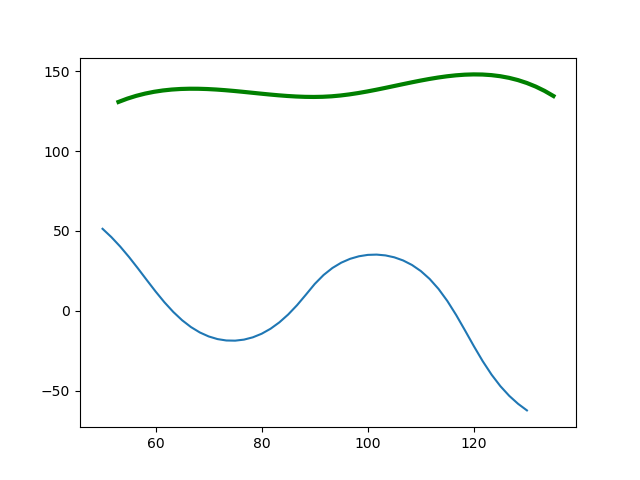

In [74]:
# now we can interpolate at equally spaced points
x_interp = np.linspace(x.min(), x.max(), num=50)
y_interp = spl(x_interp)

plt.plot(x_interp, y_interp, 'g', lw=3)

### Calculate tangent angles along the resampled backbone
Once this is done, you're really 90% of the way there!

In [75]:
# Note that we used arctan2 so we get the angle in the correct quadrant, and we use np.diff to calculate 
# the difference between successive points in the x and y vectors
angles = np.arctan2(np.diff(y_interp), np.diff(x_interp))
plt.plot(np.linspace(50, 130, num=49), np.degrees(angles))
plt.show()

### Next: calculate angles for the rest of the frames in the dataset
Once you're confident things are working as expected so far, design a loop to run through the rest of the backbones in the dataset and store them in a matrix.

## Compute eigenvectors
### Calculate covariance matrix
Useful functions: scipy.linalg.eig 

### Compute eigenvectors and eigenvalues
Useful functions: scipy.linalg.eig 

### Graph your results - see how similar they look to the original eigenworm paper!